In [1]:
import numpy as np
import pandas as pd 
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import sys
import time
import tensorflow.keras as keras
import tensorflow as tf
import re

from PIL import Image
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from keras.models import Model, Sequential
from keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

print('setup successful!')

setup successful!


In [2]:
IMAGE_WIDTH = 224    
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


# Path where our data is located
base_path = "./data/"

# Dictionary to save our 12 classes
categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash', 5: 'battery',
              6: 'shoes', 7: 'clothes', 8: 'green-glass', 9: 'brown-glass', 10: 'white-glass',
              11: 'biological'}

print('defining constants successful!')

defining constants successful!


In [3]:
# Add class name prefix to filename. So for example "/paper104.jpg" become "paper/paper104.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])
    
    filenames_list = filenames_list  +filenames
    categories_list = categories_list + [category] * len(filenames)
    
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df))

number of elements =  15515


In [4]:
df.head()

,filename,category
0,clothes/clothes4936.jpg,7
1,biological/biological96.jpg,11
2,clothes/clothes3068.jpg,7
3,shoes/shoes534.jpg,6
4,metal/metal505.jpg,3


paper/paper66.jpg


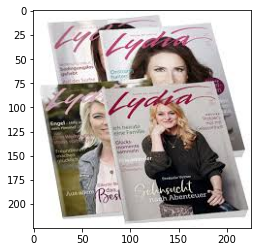

In [5]:
# see sample image, you can run the same cell again to get a different image
random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
randomimage = image.load_img(base_path +sample['filename'])
print(sample['filename'])
plt.imshow(randomimage)

Text(0, 0.5, 'Images Count')

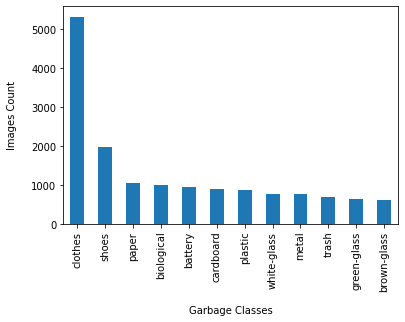

In [6]:
df_visualization = df.copy()
# Change the catgegories from numbers to names
df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
import keras.applications.mobilenet_v2 as mobilenetv2

mobilenetv2_layer = mobilenetv2.MobileNetV2(include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS),
                       weights = './mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5')

# We don't want to train the imported weights
mobilenetv2_layer.trainable = False


model = Sequential()
model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

#create a custom layer to apply the preprocessing
def mobilenetv2_preprocessing(img):
  return mobilenetv2.preprocess_input(img)

model.add(Lambda(mobilenetv2_preprocessing))

model.add(mobilenetv2_layer)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(len(categories), activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

2022-11-06 19:43:05.292238: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 12)                15372     
                                                                 
Total params: 2,273,356
Trainable params: 15,372
Non-trainable params: 2,257,984
_________________________________________________________________


In [8]:
early_stop = EarlyStopping(patience = 2, verbose = 1, monitor='val_categorical_accuracy' , mode='max', min_delta=0.001, restore_best_weights = True)

callbacks = [early_stop]

print('call back defined!')

call back defined!


In [9]:
#Change the categories from numbers to names
df["category"] = df["category"].replace(categories) 

# We first split the data into two sets and then split the validate_df to two sets
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('train size = ', total_validate , 'validate size = ', total_validate, 'test size = ', test_df.shape[0])

train size =  1551 validate size =  1551 test size =  1552


In [10]:
batch_size=64

train_datagen = image.ImageDataGenerator(
    
    ###  Augmentation Start  ###
    
    #rotation_range=30,
    #shear_range=0.1,
    #zoom_range=0.3,
    #horizontal_flip=True,
    #vertical_flip = True,
    #width_shift_range=0.2,
    #height_shift_range=0.2
    
    ##  Augmentation End  ###
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)


Found 12412 validated image filenames belonging to 12 classes.


In [11]:
validation_datagen = image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1551 validated image filenames belonging to 12 classes.


In [12]:
EPOCHS = 20
history = model.fit_generator(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

/var/folders/wj/8bxv7gcx07z_28vt568cbjx9k51gqc/T/ipykernel_72656/2716048666.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
193/193 [==============================] - 215s 1s/step - loss: 0.5714 - categorical_accuracy: 0.8358 - val_loss: 0.2895 - val_categorical_accuracy: 0.9173
Epoch 2/20
193/193 [==============================] - 209s 1s/step - loss: 0.2137 - categorical_accuracy: 0.9352 - val_loss: 0.2362 - val_categorical_accuracy: 0.9264
Epoch 3/20
193/193 [==============================] - 210s 1s/step - loss: 0.1590 - categorical_accuracy: 0.9536 - val_loss: 0.2057 - val_categorical_accuracy: 0.9349
Epoch 4/20
193/193 [==============================] - 209s 1s/step - loss: 0.1294 - categorical_accuracy: 0.9652 - val_loss: 0.1953 - val_categorical_accuracy: 0.9310
Epoch 5/20
193/193 [==============================] - 208s 1s/step - loss: 0.1079 - categorical_accuracy: 0.9717 - val_loss: 0.1949 - val_categorical_accuracy: 0.9368
Epoch 6/20
193/193 [==============================] - 209s 1s/step - loss: 0.0916 - categorical_accuracy: 0.9754 - val_loss: 0.1962 - val_categorical_accuracy: 0.938

In [13]:
model.save_weights("model12.h5")
model.save('./saved_model/')


2022-11-06 20:25:10.106480: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./saved_model/assets


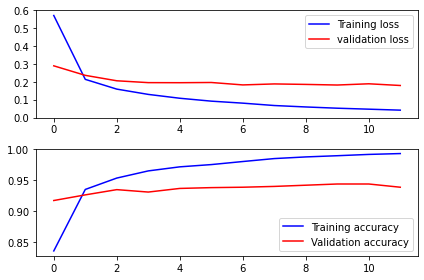

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [15]:
test_datagen = image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False 
)

Found 1552 validated image filenames belonging to 12 classes.


In [16]:
filenames = test_generator.filenames
nb_samples = len(filenames)
print(nb_samples)
_, accuracy = model.evaluate_generator(test_generator, nb_samples)

print('Accuracy on test set = ',  round((accuracy * 100),2 ), '% ') 

1552


/var/folders/wj/8bxv7gcx07z_28vt568cbjx9k51gqc/T/ipykernel_72656/1457974568.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, accuracy = model.evaluate_generator(test_generator, nb_samples)


Accuracy on test set =  94.91 % 


In [17]:
# We defined at the beginning of this notebook a dictionary that maps the categories number to names, but the train generator
# generated it's own dictionary and it has assigned different numbers to our categories and the predictions made by the model 
# will be made using the genrator's dictionary.

gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

{0: 'battery', 1: 'biological', 2: 'brown-glass', 3: 'cardboard', 4: 'clothes', 5: 'green-glass', 6: 'metal', 7: 'paper', 8: 'plastic', 9: 'shoes', 10: 'trash', 11: 'white-glass'}


In [18]:
# get the model's predictions for the test set
preds = model.predict_generator(test_generator, nb_samples)

# Get the category with the highest predicted probability, the prediction is only the category's number and not name
preds = preds.argmax(1)

# Convert the predicted category's number to name 
preds = [gen_label_map[item] for item in preds]

# Convert the pandas dataframe to a numpy matrix
labels = test_df['category'].to_numpy()

print(classification_report(labels, preds))

/var/folders/wj/8bxv7gcx07z_28vt568cbjx9k51gqc/T/ipykernel_72656/727984934.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator, nb_samples)


              precision    recall  f1-score   support

     battery       0.98      0.99      0.98        97
  biological       0.96      0.99      0.97        90
 brown-glass       0.96      0.94      0.95        49
   cardboard       0.93      0.90      0.91       100
     clothes       0.98      1.00      0.99       548
 green-glass       0.92      0.93      0.93        60
       metal       0.97      0.79      0.87        86
       paper       0.93      0.88      0.91       104
     plastic       0.74      0.89      0.81        75
       shoes       0.97      0.97      0.97       195
       trash       0.97      0.97      0.97        63
 white-glass       0.90      0.85      0.87        85

    accuracy                           0.95      1552
   macro avg       0.93      0.93      0.93      1552
weighted avg       0.95      0.95      0.95      1552



In [19]:
from tensorflow.keras.preprocessing import image

dir_path = './predict'
for i in os.listdir(dir_path):
    img = image.load_img(dir_path+'//'+i, target_size=(IMAGE_SIZE), color_mode="rgb")
    X = image.img_to_array(img)

    X = np.expand_dims(X, axis = 0)

    images = np.vstack([X])
    print(images.shape)

    val = model.predict(X)
    print(np.argmax(val[0]))

(1, 224, 224, 3)
11
(1, 224, 224, 3)
8
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
8
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
7
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1, 224, 224, 3)
11
(1,

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x13b53bea0>